# Proje Tanımı ve Hedefler
Bu proje, bir e-ticaret şirketinin geçmiş sipariş verilerini inceleyerek müşteri davranışlarını analiz etmeyi ve bu analizler doğrultusunda hem segmentasyon hem de satın alma tahmini yapmayı amaçlamaktadır.

### **Projemin detayları:**
-  Müşterileri **Recency (yenilik)**, **Frequency (sıklık)** ve **Monetary (harcama)** metriklerine göre analiz ederek segmentlere ayırmak  
- Bu segmentleri anlamlı müşteri gruplarına dönüştürmek (örneğin: sadık müşteriler, kaybedilen müşteriler vb.)  
- Müşterilerin **gelecekte tekrar alışveriş yapma olasılıklarını** makine öğrenmesi yöntemleri ile tahmin etmek  
- Pazarlama stratejileri açısından anlamlı içgörüler sunmak ve segmentlere özel öneriler geliştirmek

Bu proje hem teknik becerilerimi geliştirmek hem de gerçek bir iş problemine veri bilimi bakış açısıyla yaklaşmak amacıyla gerçekleştirilmiştir.

In [244]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import lightgbm as lgb
from sklearn.model_selection import train_test_split


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-dataset/online_retail.csv


In [245]:
df = pd.read_csv("/kaggle/input/online-retail-dataset/online_retail.csv")

# Verinin İlk İncelemesi (Data Exploration)

In [246]:
# ilk 5 satır
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Veriye ilk baktığımda her satırın tek bir ürün işlemine karşılık geldiğini fark ettim. Aynı `InvoiceNo` numarasına sahip birden fazla satır olması, tek bir siparişte birden fazla ürün alınabildiğini gösteriyor. Bu yüzden sipariş bazlı analiz yaparken bunları gruplayarak değerlendirmem gerekebilir.

`CustomerID` sütununun float formatında olduğunu gördüm ama bu aslında bir kategorik bilgi. İlerleyen adımlarda onu `int` ya da `str` formatına çevirmeyi düşünüyorum. Çünkü modelleme aşamasında bu sütunu doğrudan kullanmak istersem düzgün bir formatta olması önemli olacak.

`InvoiceDate` zaman damgası içeren bir sütun ve bu özellikle **recency** hesaplamaları ve zaman bazlı analizler için işime çok yarayacak. Zaman serisi mantığında düşüneceğim bölümler için burada detaylı analizler yapmayı planlıyorum.

İlk satırlardaki `Quantity` ve `UnitPrice` değerleri pozitif görünüyor ama iade işlemlerinin bu veri setinde yer aldığını biliyorum. O yüzden ileride negatif değerleri de filtrelemem gerekecek gibi duruyor.

Son olarak, `Country` sütunu sayesinde siparişlerin hangi ülkeye yapıldığını görebiliyorum. Özellikle Birleşik Krallık verilerinin ağırlıklı olduğunu tahmin ediyorum ama bunu netleştirmek için ayrı bir analiz yapacağım.

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB



Veri setinde toplamda 541.909 satır ve 8 sütun var. İlk dikkatimi çeken şey, çoğu sütunda eksik veri yok ama `Description` ve özellikle `CustomerID` sütunlarında eksikler mevcut.

`CustomerID` sadece 406.829 satırda dolu, yani yaklaşık 135.000 kayıt eksik. Müşteri bazlı analizler yapacağım için bu sütunu kullanmadan önce eksik verileri temizlemem gerekecek.

Sütunların veri tiplerine baktığımda çoğunun `object` formatında olduğunu görüyorum. Özellikle `InvoiceDate` sütunu henüz datetime formatında değil ve bu sütunu dönüştürmek benim için önemli çünkü ileride zaman bazlı analizler yapacağım.

Ayrıca `CustomerID` sütunu `float64` olarak görünüyor ama aslında sayısal bir ID. Bu sütunu da daha okunabilir ve anlamlı bir hale getirmek için muhtemelen `int` ya da `string` formatına çevireceğim.

Genel olarak veri yapısı oldukça temiz görünüyor ve temel analizlere başlamak için uygun durumda.

In [248]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

Veri setinde toplam 8 adet sütun var ve ilk bakışta her biri analiz sürecinde önemli bir rolde  gibi duruyor. Özellikle `InvoiceNo`, `StockCode`, `Description` ve `CustomerID` gibi sütunlar bana siparişin kim tarafından, ne zaman ve ne satın alındığını anlamamda yardımcı olacak.

`Quantity` ve `UnitPrice` sütunları sayesinde her bir işlemde kaç ürün alındığını ve ürünün fiyatını görebiliyorum ve bu da ileride toplam harcama (`TotalPrice`) hesaplamaları yaparken işime çok yarayacak.

`InvoiceDate` sütunu siparişin tam zamanını veriyor ama henüz datetime formatında değil.

Son olarak `Country` sütunu, işlemin hangi ülkeye ait olduğunu gösteriyor. Bölgesel analizlerde ve pazarlama segmentasyonu açısından oldukça faydalı olabilir.


In [249]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Bu çıktıya baktığımda ilk dikkatimi çeken şey `Quantity` ve `UnitPrice` sütunlarındaki negatif değerler oldu. Mesela `Quantity`'de minimum değer -80995, `UnitPrice`'ta ise -11062 gibi bir sayı var. Bunlar muhtemelen iadeleri ya da sistem hatalarını gösteriyor. İlerleyen adımlarda bunları detaylıca filtrelemem gerekecek.

Ortalama alınan ürün sayısı 9.5 gibi gözüküyor ama standart sapması 218 olduğu için bazı alışverişlerin aşırı büyük adetlerde yapıldığını tahmin ediyorum. Yani veri biraz dağınık ve uç değerler var gibi duruyor.

Fiyatlar da benzer şekilde. Ortalama birim fiyat 4.6 ama maksimum 38.970 çıkmış. Bu da bana bazı ürünlerin fiyatlarının çok yüksek olduğunu ya da belki hatalı girildiğini düşündürüyor. Zaten bunları görselleştirme adımında netleştireceğim.

`CustomerID` sayısal gibi gözükse de aslında kategorik bir bilgi. Buradaki sayılar kimlik numarası gibi, o yüzden büyüklüklerinin bir anlamı yok ama yine de eksik değerleri temizlemek gerekecek.


## İade Kayıtlarının ve Negatif Miktarların İncelenmesi `(Quantity < 0)` : İade İşlemleri mi?

In [250]:
print("Negatif Quantity:", (df['Quantity'] < 0).sum())
print("Negatif UnitPrice:", (df['UnitPrice'] < 0).sum())


Negatif Quantity: 10624
Negatif UnitPrice: 2


In [251]:
df[df['Quantity'] < 0].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Negatif `Quantity` değerlerine göz attığımda, ilk birkaç satırdan itibaren bunların büyük olasılıkla **iade işlemlerini** temsil ettiğini açıkça görebiliyorum.  
Özellikle `InvoiceNo`'ların başında genellikle **"C" harfi** bulunması bu durumu destekliyor.

Bazı ürünlerde `Quantity` -12, hatta -24 gibi yüksek değerlere ulaşmış. Bu da tek seferde **toplu iade** yapıldığını düşündürüyor.  
Ayrıca `"Discount"` gibi açıklamalı satırlar da mevcut — bu da işlemlerin sadece ürün iadeleriyle sınırlı olmadığını gösteriyor olabilir.

---

### Neden Önemli?

İleri analizlerde (RFM, müşteri segmentasyonu, satın alma tahmini vb.) bu iadeler büyük ihtimalle analizleri bozabilir. Bu nedenle ilerleyen adımlarda bu kayıtları **filtreleyerek daha temiz bir veri seti** oluşturmam mantıklı olacaktır.

> **Not :** Bu kayıtlar tamamen silinmek yerine, **ayrı bir grup olarak** tutulup *memnuniyetsizlik, şikâyet davranışı* gibi farklı açılardan ayrıca analiz edilebilir.

In [252]:
df[df['UnitPrice'] < 0].head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Negatif `UnitPrice` değerlerine göz attığımda, açıkçası biraz şaşırdım çünkü ürün fiyatlarının eksi olması pek mantıklı değil. Fakat açıklama kısmında "Adjust bad debt" yazısını görünce bunun bir ürün satışı değil, finansal düzeltme işlemi olduğunu fark ettim.

Bu tür kayıtlar genellikle şirketin zarar yazdığı ya da kötü borçları kapattığı satırlar oluyor. Zaten `CustomerID` de boş bırakılmış, yani bu işlemlerin bir müşteriye özel olmadığı belli.

Fiyatın -11062 gibi uç bir değerde olması, bu satırın istisnai bir işlem olduğunu daha da netleştiriyor. Bu tarz kayıtlar benim analizimin konusu olan alışveriş davranışları, segmentasyon ya da tekrar satın alma tahmini gibi amaçlarla hiç örtüşmüyor.

O yüzden bu kayıtları doğrudan analiz dışı bırakacağım. Fakat bu adımı özellikle not ediyorum çünkü veri temizliği yaparken "neyi neden sildiğimi" bilmek önemli.

In [253]:
# Tüm sütunlardaki eksik değer sayısı
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [254]:
# Eksik değer oranlarını yüzdesel olarak yazdıralım
((df.isnull().sum() / len(df)) * 100).round(2)


InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

En çok eksikliğin `CustomerID` sütununda olduğunu zaten daha önceki çıktılarda görmüştüm. Toplamda 135.080 kayıt, yani tüm verinin yaklaşık %25’i, müşteri ID’si içermiyor. Bu benim için kritik çünkü müşteri bazlı analizler (özellikle RFM segmentasyonu) yapacağım için bu kayıtlarla ilerlemem mümkün değil. Dolayısıyla, bu eksik kayıtları ileride veri setinden çıkarmam ya da uygun şekilde doldurmam gerekecek.

`Description` sütununda ise %0.27 gibi çok küçük bir eksik oranı var. Bu ürün açıklamalarının bazı işlemlerde girilmediğini gösteriyor. Bu sütun analizimin ana odağında olmadığı için bu eksik değerleri şimdilik veri dışına itmeden devam etmeyi planlıyorum.


## Aykırı Değer

Veri setinde aslında 8 farklı sütun var ama aykırı değer analizi için özellikle `Quantity` ve `UnitPrice` üzerine odaklandım. Çünkü:

- Bu iki sütun **sayısal ve sürekli değişen** yapıda.  
- Diğer sütunlar ya **kategorik** (`InvoiceNo`, `Country`, `StockCode`, `CustomerID`) ya da **tarih/isim gibi** (`InvoiceDate`, `Description`) analiz açısından doğrudan aykırı değerlere sahip olabilecek değişkenler değil.

`Quantity` ve `UnitPrice` ise doğrudan **alınan ürün miktarını** ve **birim fiyatı** gösterdiği için:
- Anlamsız yüksek değerler (örneğin 80.000 adet ürün ya da 38.000 birim fiyat gibi) analiz sonuçlarını ciddi şekilde bozabilir.
- Özellikle RFM hesaplamaları, segmentasyon ve makine öğrenmesi gibi adımlarda bu tür uç değerler modelin öğrenmesini etkileyebilir.

Bu yüzden sadece bu iki sütun için detaylı bir aykırı değer analizi yapmayı tercih ettim. Gerektiğinde diğer sütunlar da bağlama göre incelenebilir ama temel odak bu iki alanda olacak.

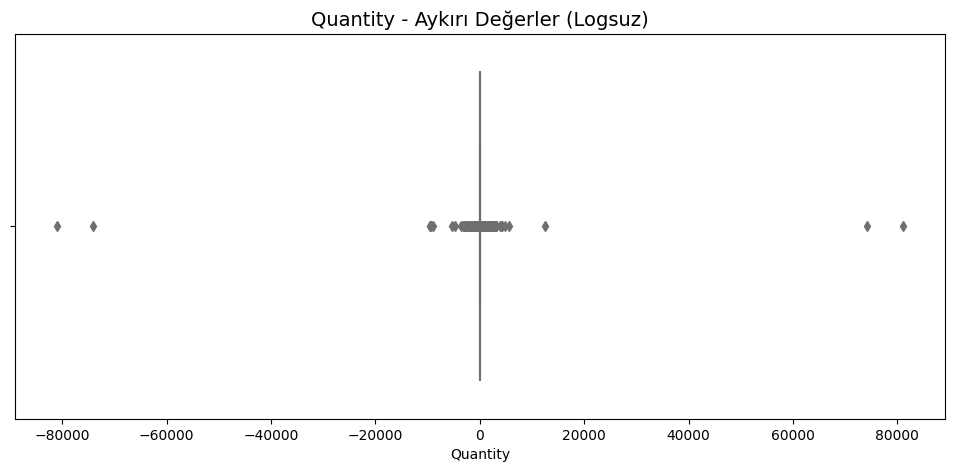

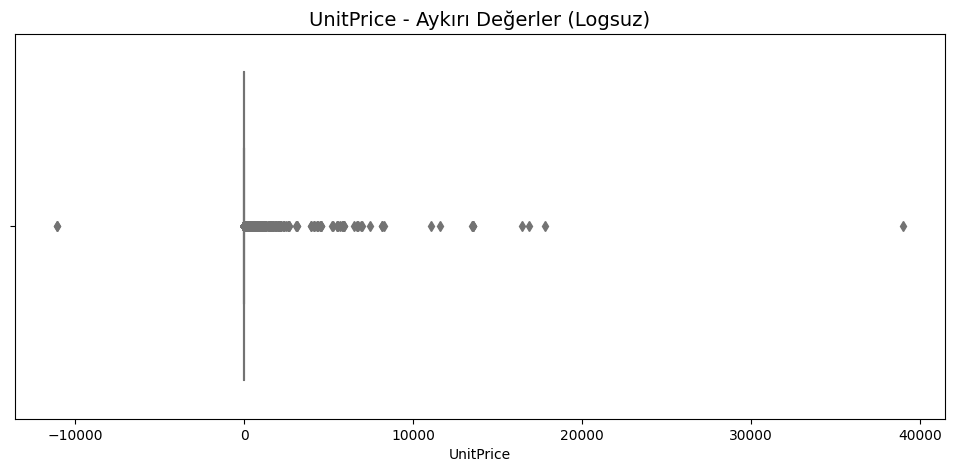

In [255]:
# Quantity
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['Quantity'], color='skyblue')
plt.title("Quantity - Aykırı Değerler (Logsuz)", fontsize=14)
plt.xlabel("Quantity")
plt.show()

# Unitprice
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['UnitPrice'], color='lightgreen')
plt.title("UnitPrice - Aykırı Değerler (Logsuz)", fontsize=14)
plt.xlabel("UnitPrice")
plt.show()

Bu grafikleri oluşturduğumda, özellikle `Quantity` ve `UnitPrice` değişkenlerinde ciddi şekilde uç noktalarda değerler olduğunu açıkça gördüm.

- `Quantity` tarafında hem negatif hem de pozitif uçlarda değerler var. Negatif olanlar büyük ihtimalle iade işlemlerine karşılık geliyor, daha önce de fark ettiğim gibi bazı kayıtlar -80.000 gibi inanılmaz yüksek sayılarda. Bu tarz değerler RFM analizinde doğrudan etki yaratacağı için mutlaka filtrelemem gerekecek.

- `UnitPrice` için de benzer bir durum söz konusu. Grafik üzerinde 30.000–40.000 gibi uç fiyatlara sahip ürünler var. Bunların bir kısmı gerçekten pahalı ürünler olabilir ama veri hatası olma ihtimali de göz ardı edilemez.

Bu grafikleri log dönüşümsüz oluşturarak ham verinin yapısını bozmadım. Çünkü şu an amacım aykırı değerleri **temizlemek değil, tanımak**. Modelleme ya da segmentasyon öncesinde bu değerlerin varlığını bilmek önemli. Temizleme kararı verirsem, hangi değerlere müdahale etmem gerektiğini artık çok net biliyorum.

# Veriyi Parlatma Zamanı: Eksik ve Aykırı Değerlerden Arındırma

### 1.1 `CustomerID` Eksik Verileri
Bu sütun, müşteri bazlı analizlerde kritik öneme sahip. Ancak verinin %24.93'ü eksik.
Bu satırlarda müşteri kimliği olmadığı için:

* RFM (Recency, Frequency, Monetary) gibi müşteri odaklı analizlerde kullanılamazlar.Bu yüzden bu satırları veri setinden çıkarmak mantıklı bir seçim olacak.

In [256]:
# CustomerID bilgisi olmayan satırları veri setinden çıkarma
df = df[~df['CustomerID'].isnull()]


### 1.2 `Description` Eksik Verileri
Bu sütundaki eksik oran sadece %0.27. Yani toplamda 1454 satır.
Bu kadar küçük bir oran, istatistiksel anlamda analizleri çok fazla etkilemez.

In [257]:
# Description değeri eksik olan satırları silme
df = df[~df['Description'].isnull()]


### 1.3 Aykırı Değerlerden Arındırma

#### **1.3.1 Aykırı Değerleri Tespit Etme Yöntemi: IQR**

In [258]:
def remove_outliers_verbose(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    print(f"\n Aykırı Değer Tespiti - {column}")
    print(f"Q1 (1. Çeyrek): {Q1}")
    print(f"Q3 (3. Çeyrek): {Q3}")
    print(f"IQR: {IQR}")
    print(f"Aykırı Değer Alt Sınırı: {lower_limit}")
    print(f"Aykırı Değer Üst Sınırı: {upper_limit}")
    
    before = df.shape[0]
    df_cleaned = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    after = df_cleaned.shape[0]
    
    print(f"Temizlenen Satır Sayısı: {before - after}")
    print(f"Kalan Satır Sayısı: {after}")
    
    return df_cleaned


In [259]:
# Quantity için
df = remove_outliers_verbose(df, 'Quantity')

# UnitPrice için
df = remove_outliers_verbose(df, 'UnitPrice')



 Aykırı Değer Tespiti - Quantity
Q1 (1. Çeyrek): 2.0
Q3 (3. Çeyrek): 12.0
IQR: 10.0
Aykırı Değer Alt Sınırı: -13.0
Aykırı Değer Üst Sınırı: 27.0
Temizlenen Satır Sayısı: 26682
Kalan Satır Sayısı: 380147

 Aykırı Değer Tespiti - UnitPrice
Q1 (1. Çeyrek): 1.25
Q3 (3. Çeyrek): 3.75
IQR: 2.5
Aykırı Değer Alt Sınırı: -2.5
Aykırı Değer Üst Sınırı: 7.5
Temizlenen Satır Sayısı: 35754
Kalan Satır Sayısı: 344393


# Özellik Mühendisliği

## 1. `TotalPrice` (Toplam Satış Tutarı)
Bir işlemdeki toplam harcamayı bilmek, hem müşterinin hem ürünün önemini belirlemede kritik.
Özellikle RFM analizi ve satış analizlerinde çok işimize yarayacak.

In [260]:
# Quantity ve UnitPrice çarpımı ile her işlemdeki toplam tutarı hesapla
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


## 2. Zaman Tabanlı Değişkenler
Zamansal analiz yapmak için satın alma davranışlarını gün, ay, saat gibi detaylarda göstermek en iyisidir. Sezonluk trendler, alışveriş yoğunluğu gibi analizleri bu verilerle çıkarabiliriz.

In [261]:
# Tarih tipine çevir
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Yıl-Ay bilgisi (ör: 2010-12)
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Haftanın günü (0: Pazartesi, 6: Pazar)
df['Weekday'] = df['InvoiceDate'].dt.dayofweek

# Günün saati
df['Hour'] = df['InvoiceDate'].dt.hour

# Ay bilgisi
df['Month'] = df['InvoiceDate'].dt.month


## 3. Müşteri Bazlı Özellikler

### 3.1 Müşterinin Toplam Harcaması

In [262]:
# Müşterinin toplam harcaması
customer_total = df.groupby('CustomerID')['TotalPrice'].sum().reset_index(name='CustomerTotalSpent')

### 3.2 Müşterinin Yaptığı Toplam Alışveriş Sayısı

In [263]:
# Müşterinin yaptığı toplam alışveriş sayısı
customer_freq = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index(name='CustomerOrderCount')

In [264]:
# Ana veriye birleştir
df = df.merge(customer_total, on='CustomerID', how='left')
df = df.merge(customer_freq, on='CustomerID', how='left')

## 4. `IsWeekend` – Hafta Sonu mu?
Müşteriler hafta sonu ve hafta içi farklı alışveriş davranışı gösterebilir. Bu pazarlama stratejileri için önemli bir özelliktir.

In [265]:
# 5 = Cumartesi, 6 = Pazar
df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

## 5. `InvoiceHourCategory` – Saat Kategorisi
Müşterilerin sabah mı, öğle mi yoksa akşam saatlerinde mi alışveriş yaptığı analiz edilebilir.

In [266]:
def categorize_hour(hour):
    if hour < 6:
        return 'Night'
    elif hour < 12:
        return 'Morning'
    elif hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df['InvoiceHourCategory'] = df['Hour'].apply(categorize_hour)


## 6. `BasketSizePerInvoice` – Faturadaki Ürün Sayısı
Bir faturada kaç adet ürün alınmış? Müşterinin sepet büyüklüğünü analiz etmek için.

In [267]:
invoice_qty = df.groupby('InvoiceNo')['Quantity'].sum().reset_index(name='BasketSize')
df = df.merge(invoice_qty, on='InvoiceNo', how='left')


## 7. `PricePerItem` – Ürün Başına Düşen Ortalama Fiyat
Müşteriler yüksek fiyatlı mı yoksa ucuz ürünler mi tercih ediyor bunu görebilmem için.

In [268]:
df['PricePerItem'] = df['TotalPrice'] / df['Quantity']


## 8. `IsHighValueInvoice` – Yüksek Tutar mı?
İleride belirli bir eşik üzerindeki faturaları işaretleyerek VIP alışverişleri tespit edilirim.

In [269]:
df['TotalPrice'].describe()


count    344393.000000
mean         12.398313
std          13.390289
min         -81.000000
25%           3.750000
50%           9.960000
75%          17.220000
max         178.800000
Name: TotalPrice, dtype: float64

## Yüksek Değerli Faturaların Belirlenmesi

Veri setindeki `TotalPrice` sütununa göre, faturalardaki harcama miktarlarının dağılımını inceledim. Harcama değerlerinin oldukça geniş bir dağılım gösterdiğini gördüm:

- Medyan harcama: 9.96
- Üst %25 dilimi (Q3): 17.22
- Maksimum harcama: 178.80

Bu bilgiler ışığında, yüksek değerli faturaları belirlemek için **Q3 üzeri harcamaları** işaretleyen yeni bir sütun oluşturdum:

In [270]:
# TotalPrice için Q3 (75. yüzdelik dilim) değeri belirle
threshold = df['TotalPrice'].quantile(0.75)

# Yüksek değerli fatura olup olmadığını belirten yeni bir sütun oluştur
df['IsHighValueInvoice'] = df['TotalPrice'].apply(lambda x: 1 if x > threshold else 0)

# Eşik ve örnek sayısı gösterimi
print(f"Yüksek değerli fatura eşiği: {threshold:.2f}")
print("Yüksek değerli fatura sayısı:", (df['IsHighValueInvoice'] == 1).sum())
print("Düşük değerli fatura sayısı:", (df['IsHighValueInvoice'] == 0).sum())

# Oransal dağılımı da görelim
print("\nOransal Dağılım:")
print(df['IsHighValueInvoice'].value_counts(normalize=True))


Yüksek değerli fatura eşiği: 17.22
Yüksek değerli fatura sayısı: 86091
Düşük değerli fatura sayısı: 258302

Oransal Dağılım:
IsHighValueInvoice
0    0.750021
1    0.249979
Name: proportion, dtype: float64


# EDA – Keşifsel Veri Analizi

Feature engineering adımında veriyi anlamlı hale getirdikten sonra, bu analizleri daha sağlıklı yapabilmek adına EDA aşamasını bu noktada gerçekleştirmeyi tercih ettim.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


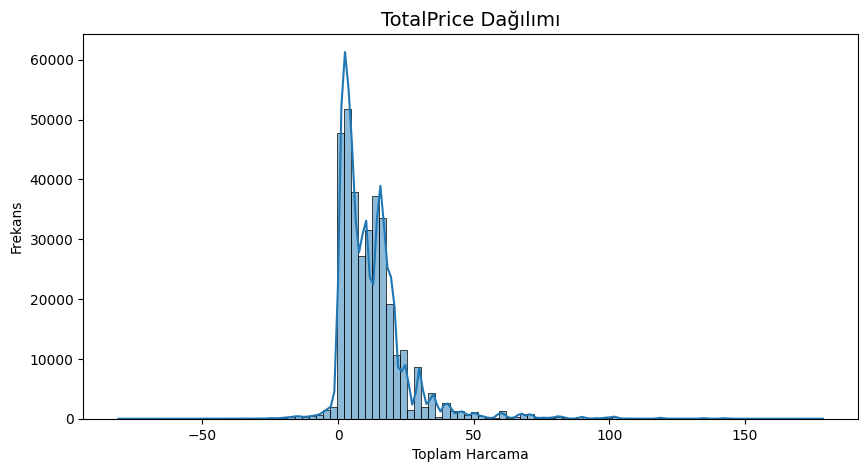

In [271]:
# TotalPrice’in dağılımı
plt.figure(figsize=(10, 5))
sns.histplot(df['TotalPrice'], bins=100, kde=True)
plt.title("TotalPrice Dağılımı", fontsize=14)
plt.xlabel("Toplam Harcama")
plt.ylabel("Frekans")
plt.show()

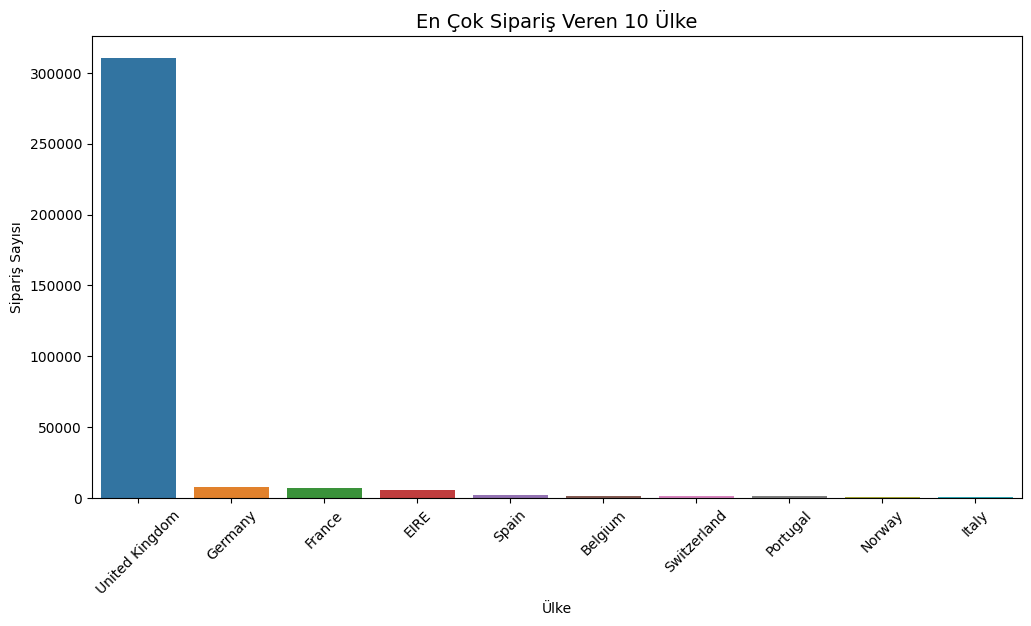

In [272]:
# Ülkelere göre toplam sipariş sayısı
country_orders = df['Country'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_orders.index[:10], y=country_orders.values[:10])
plt.xticks(rotation=45)
plt.title("En Çok Sipariş Veren 10 Ülke", fontsize=14)
plt.ylabel("Sipariş Sayısı")
plt.xlabel("Ülke")
plt.show()

Grafiğe baktığımda görüyorum ki United Kingdom (Birleşik Krallık) açık ara en çok sipariş veren ülke! Sipariş sayısı öyle yüksek ki, diğer ülkeler onun yanında neredeyse görünmez kalıyor.
* United Kingdom, veri setinde dominant. Sipariş sayısı 300.000’in çok üzerinde.

* Diğer ülkeler arasında Germany, France, EIRE, Spain, Belgium, Switzerland, Portugal, Norway ve Italy yer alıyor. Ama hiçbirinin siparişi 10.000 barajını aşamıyor.

* UK'yi ayrı bir segment olarak ele almak daha mantıklı olabilir. Diğer ülkeleri de birlikte gruplayarak karşılaştırmalı analiz yapmayı planlıyorum.

Modelleme aşamasında, eğer sadece UK verisiyle çalışırsam, modelin genellenebilirliği sıkıntıya girebilir. O yüzden bu dağılımı dikkate alarak ilerlemek şart.

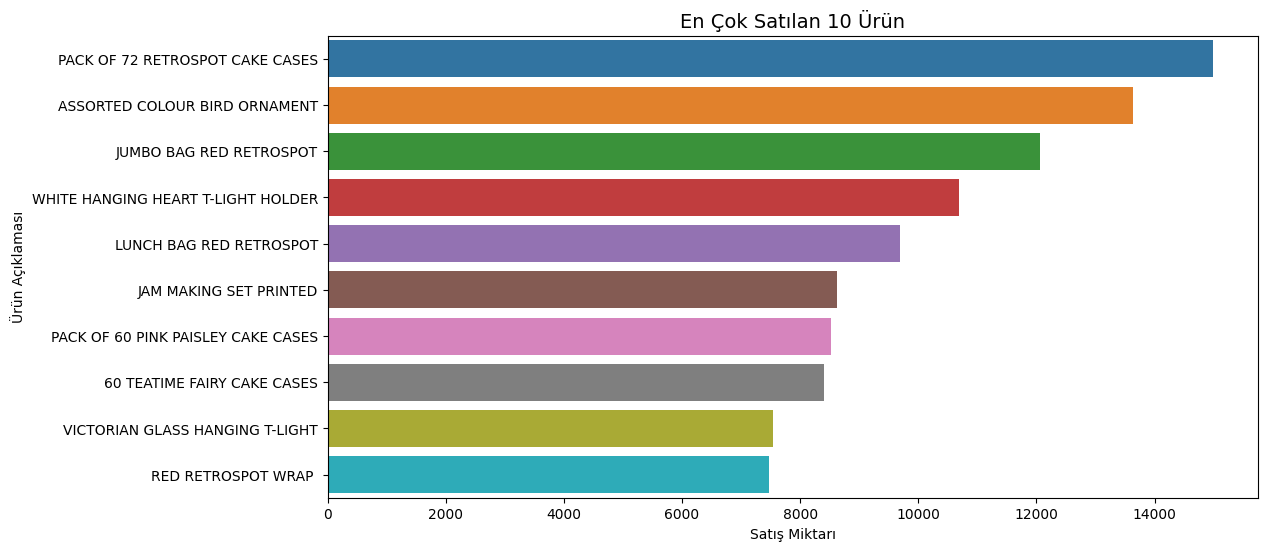

In [273]:
# En çok satılan ürünler
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("En Çok Satılan 10 Ürün", fontsize=14)
plt.xlabel("Satış Miktarı")
plt.ylabel("Ürün Açıklaması")
plt.show()


Bu grafikte en çok satış yapılan 10 ürünün dağılımını inceledim. Listenin zirvesinde "PACK OF 72 RETROSPOT CAKE CASES" var ve gerçekten açık ara farkla önde. Demek ki müşteriler cupcake veya kek sunumlarına çok düşkün. Onu takip eden ürünler ise yine genelde dekoratif ya da mutfakla ilgili ürünler. Özellikle:

- Ornament (süs eşyası) ve çanta gibi ürünlerin çok satılması, kullanıcıların hem kendileri hem de hediye amaçlı alışveriş yaptığını düşündürüyor.

- Ürün isimlerinde sık sık geçen "RETROSPOT" ibaresi de dikkatimi çekti. Bu belli ki markanın veya temanın popüler bir versiyonu.

- Ayrıca mumluklar da (T-LIGHT HOLDER) listede yer alıyor, bu da ev dekorasyon ürünlerinin talep gördüğünü gösteriyor.

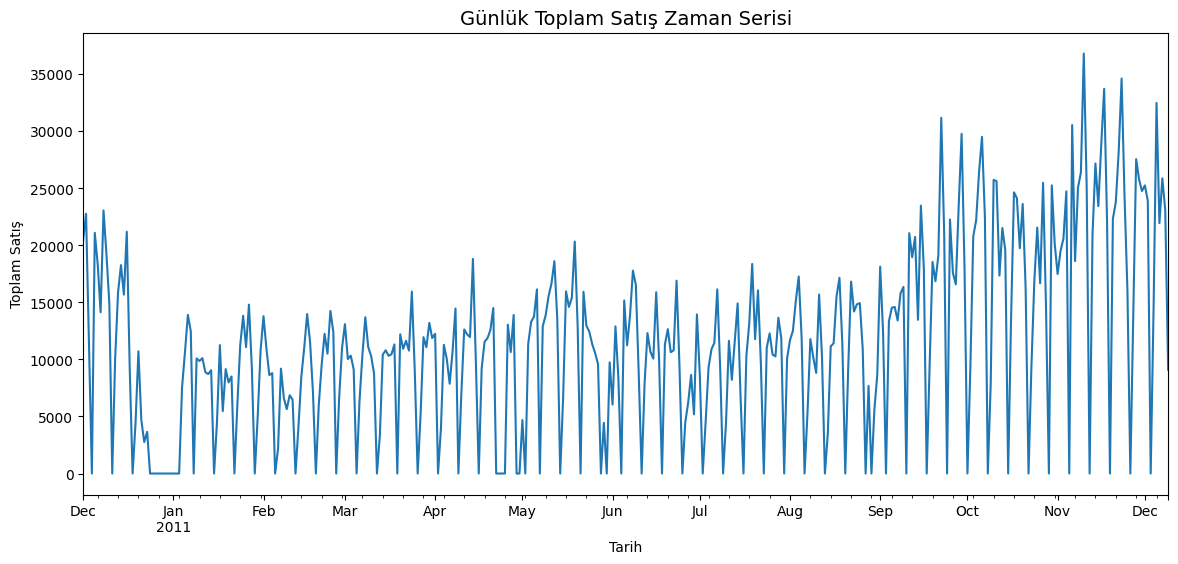

In [274]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Günlük toplam satış
daily_sales = df.set_index("InvoiceDate").resample("D")["TotalPrice"].sum()

plt.figure(figsize=(14, 6))
daily_sales.plot()
plt.title("Günlük Toplam Satış Zaman Serisi", fontsize=14)
plt.ylabel("Toplam Satış")
plt.xlabel("Tarih")
plt.show()


Bu zaman serisi grafiğinde 2011 yılı boyunca gerçekleşen günlük toplam satışları görüyoruz. Grafik genel olarak bana birkaç şey söylüyor:

Yılın başında (Ocak-Mart gibi), satışlar daha düşük ve dalgalı seyretmiş. Özellikle Ocak ayında bazı günlerde neredeyse hiç satış yapılmamış gibi duruyor.

Yaza doğru (Nisan – Temmuz arası) daha istikrarlı bir artış başlıyor. Sanırım bu dönemde kampanyalar ya da özel günler olabilir.

En dikkat çeken şey ise Eylül ayından itibaren başlayan büyük sıçrama. Satışlar ciddi oranda artıyor ve Kasım – Aralık aylarında adeta zirve yapıyor. Bu dönem, tatil sezonu ve yılbaşı alışverişleriyle bağlantılı olabilir.

Ayrıca genel bir yükseliş trendi gözlemliyorum. Yıl boyunca satış hacmi yavaş yavaş artmış gibi.

>  Yılın son çeyreği satışlar açısından çok kritik. Eğer bir satış stratejisi geliştirilecekse, bu döneme özel kampanyalar planlamak mantıklı olur

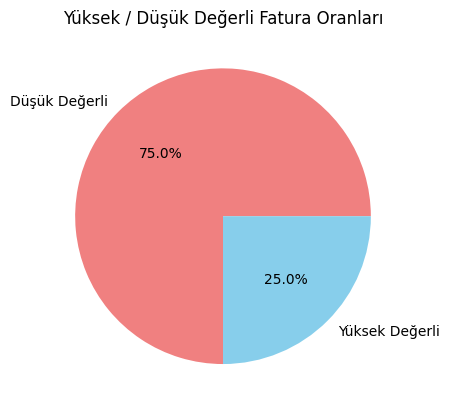

In [275]:
# Yüksek vs düşük fatura oranları
df['IsHighValueInvoice'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', labels=["Düşük Değerli", "Yüksek Değerli"], colors=["lightcoral", "skyblue"])
plt.title("Yüksek / Düşük Değerli Fatura Oranları")
plt.ylabel("")
plt.show()


Pasta grafiği gösteriyor ki Faturaların %75’i düşük değerli, yani çoğu müşteri küçük tutarlarda alışveriş yapmış.Geriye kalan %25’lik kesim ise yüksek değerli fatura oluşturmuş, yani daha fazla harcayan daha az sayıda ama etkili bir müşteri grubu var.
> Belki de müşterilerin büyük kısmı kampanyalı veya uygun fiyatlı ürünlere yöneliyor. Ama öte yandan, daha yüksek harcama yapan o %25’lik kesimi VIP müşteri gibi ele alıp, özel teklifler ve sadakat programları ile daha çok elde tutmak mantıklı olabilir

In [276]:
# 2. Analiz tarihi: Veri setindeki son tarihten bir gün sonrası
analysis_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# 3. RFM hesaplaması
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

# 4. Sütun isimlerini güncelle
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [277]:
rfm['WillPurchaseAgain'] = rfm['Frequency'].apply(lambda x: 1 if x > 3 else 0)


In [278]:
rfm.head()


,CustomerID,Recency,Frequency,Monetary,WillPurchaseAgain
0,12347.0,2,7,3314.73,1
1,12348.0,249,3,90.20,0
2,12349.0,19,1,999.15,0
3,12350.0,310,1,294.40,0
4,12352.0,36,8,1010.61,1


### 1. Hedef değişkeni oluşturma

In [279]:
# Cut-off tarihi belirleme
cutoff_date = df['InvoiceDate'].max() - dt.timedelta(days=90)

# Her müşterinin son alışveriş tarihi
last_purchase = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']

# Cut-off tarihinden sonra alışveriş yaptıysa 1, yapmadıysa 0 etiketi
last_purchase['WillPurchaseAgain'] = last_purchase['LastPurchaseDate'].apply(lambda date: 1 if date > cutoff_date else 0)

# Ana veriye hedef değişkeni ekleme
df = df.merge(last_purchase[['CustomerID', 'WillPurchaseAgain']], on='CustomerID', how='left')


In [280]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import lightgbm as lgb


In [281]:
# Modelleme için sayısal olmayan sütunları çıkarma
X = df.drop(columns=['WillPurchaseAgain', 'CustomerID', 'InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country', 'InvoiceYearMonth', 'InvoiceHourCategory'])

# Hedef değişken
y = df['WillPurchaseAgain']


In [282]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [283]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)


LGBMClassifier(random_state=42)

In [284]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9677405304955066
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86      8261
           1       0.97      0.99      0.98     60618

    accuracy                           0.97     68879
   macro avg       0.94      0.90      0.92     68879
weighted avg       0.97      0.97      0.97     68879

Confusion Matrix:
 [[ 6668  1593]
 [  629 59989]]


Eğittiğim modelin doğruluk oranı (accuracy) %96.77 gibi oldukça yüksek bir değer verdi. İlk bakışta çok başarılı gibi görünse de, detaylara inince bu durumun overfitting (aşırı öğrenme) belirtisi olabileceğini fark ettim.

**Sınıf Dengesizliği:**
Modelin hedef değişkeni olan WillPurchaseAgain sınıflarına baktığımda:

* 1 (yeniden alışveriş yapacak): 60.618 kişi

* 0 (yapmayacak): 8.261 kişi

Yani sınıflar arasında ciddi bir dengesizlik var. Bu durumda model, çoğunluk sınıfa (1) ağırlık vererek ezbere tahmin yapabiliyor. Bu da yüksek accuracy ile yanıltıcı bir başarı gösterebiliyor.

**Recall farkı:**
Yeniden alışveriş yapacak müşterilerde (1) recall değeri %99 gibi çok yüksek.
Ancak alışveriş yapmayacaklarda (0) recall sadece %81.
Bu fark, modelin çoğunlukla "alışveriş yapacak" tahmini yaptığını gösteriyor.

**Confusion matrix:**
* 1.593 kişiye yapacak demiş ama aslında yapmayacaklardı (false positive).

* 629 kişiye yapmayacak demiş ama aslında yapacaklardı (false negative).

Bu da modelin daha çok 1 sınıfına yöneldiğini gösteriyor.

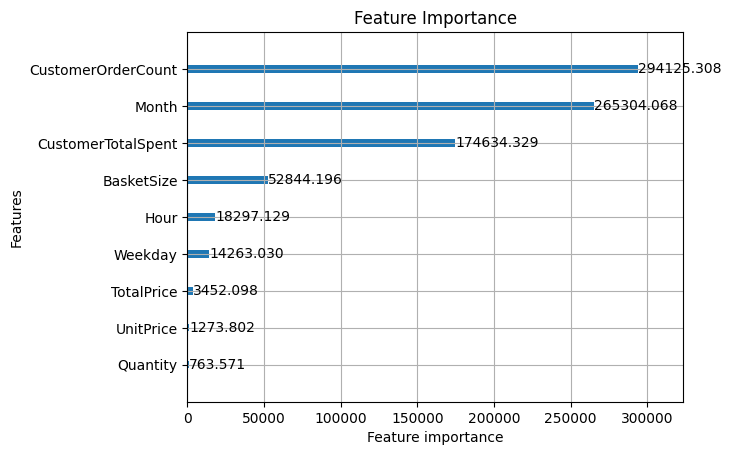

In [285]:
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Feature Importance")
plt.show()


Modelin hangi değişkenlere ne kadar önem verdiğine baktığımda, en çok etkili olanların müşteri bazlı davranışlarla ilgili olduğunu gördüm.

En yüksek etkiye sahip değişkenler:
* CustomerOrderCount:
Açık ara en önemli özellik. Yani bir müşterinin kaç kez sipariş verdiği, tekrar alışveriş yapıp yapmayacağını belirlemede model için en güçlü sinyal olmuş. Bu da aslında oldukça mantıklı çünkü düzenli sipariş veren biri alışverişe devam etme eğilimindedir.

* Month:
Siparişlerin gerçekleştiği ay bilgisi de oldukça etkili. Sezonsallık ya da kampanya dönemleri gibi dışsal faktörlerin müşteri davranışına ciddi etkisi var gibi duruyor.

* CustomerTotalSpent:
Müşterinin şimdiye kadar yaptığı toplam harcama da önemli bir faktör olmuş. Yani çok harcayan müşteri, markaya daha bağlı olabilir ve yeniden alışveriş yapma ihtimali daha yüksek olabilir.

Orta düzeyde etkili değişkenler:
* BasketSize:
Sepet büyüklüğü de belli bir önem taşıyor. Daha büyük sepet yapan müşteriler, alışverişe olan ilgisini daha net göstermiş olabilir.

* Hour ve Weekday:
Saat ve gün gibi zamansal değişkenler de modelde etkili olmuş ama ilk üç kadar belirleyici değil. Belki alışveriş alışkanlıklarını belirli zamanlara oturtmuş müşteriler için bu değişkenler anlamlı olmuş olabilir.

Düşük öneme sahip değişkenler:
* TotalPrice, UnitPrice, Quantity:
Bu değişkenler neredeyse hiç etkili olmamış. Demek ki model, tekil ürün fiyatları ya da miktarından ziyade müşterinin genel davranışlarını daha anlamlı bulmuş.

---
Modelin en çok dikkat ettiği şey, müşterinin alışveriş geçmişiyle ilgili olan veriler. Özellikle kaç kez sipariş verdiği ve ne kadar harcadığı gibi bilgiler çok kritik. Bu da bana şunu gösteriyor: pazarlama stratejilerinde müşteri segmentasyonu yaparken bireysel işlem verilerinden çok, davranışsal veriler daha değerli. Bence bu kısım gerçekten güzel içgörüler verdi.

# Overfitting’i Azaltma – Modelin Genellenebilirliğini Artırma

Modelim eğitim verisine fazla uyum sağlamış gibi görünüyor (overfitting). Bu da test verisi üzerinde beklenenden daha düşük performans göstermesine neden olabilir. Buradaki amacım, modelin genellenebilirliğini artırarak gerçek dünyadaki performansını iyileştirmek.

Bu bölümde şunları yapacağım:
1. Karmaşıklığı azaltmak için feature sayısını düşürmek
2. Regularization (Düzenlileştirme) parametresini arttırmak
3. Early Stopping uygulamak
4. Cross Validation ile daha sağlam model değerlendirmesi yapmak

## 1. Karmaşıklığı azaltmak için feature sayısını düşürmek

In [286]:
selected_features = ['CustomerOrderCount', 'Month', 'CustomerTotalSpent', 'BasketSize', 'Hour']
X_selected = df[selected_features]
y = df['WillPurchaseAgain']


X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)


## 2. Regularization ve Early Stopping ile LightGBM Modelini Eğitmek

In [287]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'verbose': -1
}

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.112462	valid_1's binary_logloss: 0.114716
[200]	training's binary_logloss: 0.0891874	valid_1's binary_logloss: 0.0914396
[300]	training's binary_logloss: 0.0742331	valid_1's binary_logloss: 0.076665
[400]	training's binary_logloss: 0.0621604	valid_1's binary_logloss: 0.0646212
[500]	training's binary_logloss: 0.0536416	valid_1's binary_logloss: 0.0561716
[600]	training's binary_logloss: 0.0470635	valid_1's binary_logloss: 0.0495001
[700]	training's binary_logloss: 0.0413051	valid_1's binary_logloss: 0.0436674
[800]	training's binary_logloss: 0.036358	valid_1's binary_logloss: 0.0386896
[900]	training's binary_logloss: 0.0325004	valid_1's binary_logloss: 0.0347933
[1000]	training's binary_logloss: 0.0290324	valid_1's binary_logloss: 0.0313286
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0290324	valid_1's binary_logloss: 0.0313286


## 3. Cross-Validation ile Skorun Gerçekçiliğini Test Etmek

In [288]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

lgbm_model = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    lambda_l1=1.0,
    lambda_l2=1.0,
    n_estimators=1000
)

scores = cross_val_score(lgbm_model, X_selected, y, cv=5, scoring='f1')
print("Ortalama F1 Skoru:", scores.mean())


Ortalama F1 Skoru: 0.8040603804147356


## 4. Final Modeli Eğit ve Değerlendir

In [289]:
model = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=10,
    max_depth=-4,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    lambda_l1=5.0,
    lambda_l2=5.0,
    verbose= -1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

y_pred_prob = model.predict_proba(X_test)[:,1]
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))


Confusion Matrix:
[[ 4707  3554]
 [ 1049 59569]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.57      0.67      8261
           1       0.94      0.98      0.96     60618

    accuracy                           0.93     68879
   macro avg       0.88      0.78      0.82     68879
weighted avg       0.93      0.93      0.93     68879

ROC AUC Score: 0.9629590667043385


Modelim genel olarak yüksek doğrulukla çalışıyor gibi görünse de detaylara indiğimde dengesiz sınıf dağılımının etkisini net şekilde görüyorum. Özellikle "tekrar alışveriş yapmayacak" sınıfı (class 0) model tarafından yeterince iyi öğrenilememiş.

* 4707 kişinin doğru şekilde tekrar alışveriş yapmayacağı tahmin edilmiş.

* Ancak 3554 kişi yanlışlıkla tekrar alışveriş yapacak gibi tahmin edilmiş. Bu oldukça yüksek bir false positive değeri.

* Öte yandan class 1 (alışveriş yapacak) için çok iyi bir başarı oranı var: 59569 doğru tahmin, sadece 1049 yanlış.

> Modelim class 1 için neredeyse mükemmel, ama class 0 için düşük recall yüzünden zayıf bir performans sergiliyor.
Yani model, tekrar alışveriş yapmayacak çok sayıda müşteriyi yanlışlıkla alışveriş yapacak gibi tahmin ediyor.

Bu durum, iş probleminin doğasına bağlı olarak ciddi sorunlara yol açabilir. Mesela tekrar alışveriş yapmayacak biri yanlış şekilde hedeflenirse gereksiz kampanya maliyetleri doğabilir.

---
Zaman kısıtı nedeniyle bu aşamada derinlemesine iyileştirme yapma fırsatım olmadı, ancak ilerleyen süreçte:

* Özellikle class 0 için performansı artırmak adına örnekleme yöntemleri (SMOTE, undersampling vs.),

* Daha dengeli loss function'lar ya da class weight ayarları,

* Ve gerekirse farklı model denemeleriyle bu durumu iyileştirmeyi hedefliyorum.

Bu sayede modelin hem hassasiyet hem de genelleme yeteneğini daha güçlü hale getirmeyi amaçlıyorum. 